In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'LSTM-UCR-SmoothSubspace'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [0,1],
    [1,0]
]
RELEASE_FACTOR = 0.1

LR = 0.001
BATCH_SIZE = 150

TIME_STEP = 15
INPUT_SIZE = 1
OUTPUT_SIZE = 3

TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)


train_data_path = '../Datasets/UCR/SmoothSubspace/SmoothSubspace_TRAIN.tsv'
test_data_path = '../Datasets/UCR/SmoothSubspace/SmoothSubspace_TEST.tsv'
    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
        
# print(train_x)
# print(train_y)
# print(test_x)
# print(test_y)

# 留作每50轮输出当前训练结果用
train_X = train_x.copy()
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = train_y.copy()
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = train_y

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = nn.Linear(128, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        return out
    
    
# ----- Step 4: Instantiate ----- #

model = RNN()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0          

turns_index = 0
for turns in range(1, 151):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output = model(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
        
        turns_index += 1

        # Shared Part - train_output
        SP_trainout_time_part_start = time.time()
        train_output = model(train_X)
        SP_trainout_time_part_stop = time.time()

        # Shared Part - softmax
        SP_softmax_time_part_start = time.time()
        train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
        SP_softmax_time_part_stop = time.time()

        # Shared Part - pred_train_y
        SP_predy_time_part_start = time.time()
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        SP_predy_time_part_stop = time.time()

        # Acc
        acc_time_part_start = time.time()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        acc_time_part_stop = time.time()

        # MS Loss
        MS_loss_time_part_start = time.time()
        MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
        MS_loss_time_part_stop = time.time()

        # CE Loss
        loss_time_part_start = time.time()
        train_loss = loss_fn(train_output, train_Y1)
        loss_time_part_stop = time.time()

        # F1
        F1_time_part_start = time.time()
        F1 = f1_score(train_Y, pred_train_y, average='macro')
        F1_time_part_stop = time.time()

        # MCC
        MCC_time_part_start = time.time()
        MCC = matthews_corrcoef(train_Y, pred_train_y)
        MCC_time_part_stop = time.time()

        # Score
        Score_time_part_start = time.time()
        output_results = train_output_result.detach().numpy()
        prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
        confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
        confidence_pattern[confidence_pattern == -1] = 0

        total_score = 0
        pattern_num = len(confidence_pattern)
        release_factors = np.ones((pattern_num, K))

        for i in range(pattern_num):
            current_prediction_pattern = list(prediction_pattern[i])
            if train_Y[i] in current_prediction_pattern:
                correct_index = current_prediction_pattern.index(train_Y[i])
                confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                release_factors[i][correct_index] = K_release

                for release_list in RELEASE_LISTS:
                    if current_prediction_pattern[correct_index] == release_list[0]:
                        for j in range(K):
                            if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                release_factors[i][j] = RELEASE_FACTOR

        release_factors /= release_factors.sum(axis=1).reshape(-1,1)
        confidence_pattern[confidence_pattern == 0] = 1e-7
        confidence_pattern = -np.log(confidence_pattern / T_max)
        total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
        Score_time_part_stop = time.time()

        # (Test Acc)
        test_output = model(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

        print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
              '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
              '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

        turns_record.append(turns_index)
        loss_record.append(train_loss.data.numpy())
        MS_loss_record.append(MS_train_loss.data.numpy())
        train_acc_record.append(train_accuracy)
        F1_record.append(F1)
        MCC_record.append(MCC)
        Score_record.append(total_score)

        SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
        SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
        SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

        total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
        total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
        total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
        total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
        total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
        total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      


RNN(
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=3, bias=True)
)
TURNS ID:  

D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


1 | Acc: 0.3333 | F1: 0.1667 | MCC: 0.0000 | MS Loss: 0.2221 | CE Loss: 1.0979 | Score: 0.8409 | Test: 0.3333
TURNS ID:  2 | Acc: 0.3933 | F1: 0.2762 | MCC: 0.2188 | MS Loss: 0.2218 | CE Loss: 1.0967 | Score: 0.8409 | Test: 0.3533
TURNS ID:  3 | Acc: 0.4267 | F1: 0.3131 | MCC: 0.2047 | MS Loss: 0.2216 | CE Loss: 1.0958 | Score: 0.8409 | Test: 0.4800
TURNS ID:  4 | Acc: 0.4667 | F1: 0.3578 | MCC: 0.2679 | MS Loss: 0.2213 | CE Loss: 1.0947 | Score: 0.8409 | Test: 0.4933
TURNS ID:  5 | Acc: 0.4733 | F1: 0.3643 | MCC: 0.2764 | MS Loss: 0.2210 | CE Loss: 1.0933 | Score: 0.8409 | Test: 0.4933
TURNS ID:  6 | Acc: 0.4800 | F1: 0.3718 | MCC: 0.2896 | MS Loss: 0.2206 | CE Loss: 1.0915 | Score: 0.8409 | Test: 0.5000
TURNS ID:  7 | Acc: 0.4933 | F1: 0.3855 | MCC: 0.3109 | MS Loss: 0.2202 | CE Loss: 1.0894 | Score: 0.8409 | Test: 0.5267
TURNS ID:  8 | Acc: 0.5133 | F1: 0.4045 | MCC: 0.3402 | MS Loss: 0.2196 | CE Loss: 1.0868 | Score: 0.8358 | Test: 0.5400
TURNS ID:  9 | Acc: 0.5467 | F1: 0.4344 | M

TURNS ID:  69 | Acc: 0.8600 | F1: 0.8603 | MCC: 0.7945 | MS Loss: 0.0732 | CE Loss: 0.3771 | Score: 0.2777 | Test: 0.8000
TURNS ID:  70 | Acc: 0.8467 | F1: 0.8472 | MCC: 0.7727 | MS Loss: 0.0715 | CE Loss: 0.3690 | Score: 0.2684 | Test: 0.8133
TURNS ID:  71 | Acc: 0.8800 | F1: 0.8807 | MCC: 0.8205 | MS Loss: 0.0702 | CE Loss: 0.3645 | Score: 0.2641 | Test: 0.8067
TURNS ID:  72 | Acc: 0.8667 | F1: 0.8673 | MCC: 0.8004 | MS Loss: 0.0689 | CE Loss: 0.3582 | Score: 0.2582 | Test: 0.8067
TURNS ID:  73 | Acc: 0.8600 | F1: 0.8598 | MCC: 0.7934 | MS Loss: 0.0678 | CE Loss: 0.3517 | Score: 0.2585 | Test: 0.8200
TURNS ID:  74 | Acc: 0.8733 | F1: 0.8738 | MCC: 0.8136 | MS Loss: 0.0667 | CE Loss: 0.3462 | Score: 0.3029 | Test: 0.8267
TURNS ID:  75 | Acc: 0.8667 | F1: 0.8684 | MCC: 0.8058 | MS Loss: 0.0655 | CE Loss: 0.3410 | Score: 0.2955 | Test: 0.8267
TURNS ID:  76 | Acc: 0.8733 | F1: 0.8747 | MCC: 0.8150 | MS Loss: 0.0644 | CE Loss: 0.3353 | Score: 0.2892 | Test: 0.8200
TURNS ID:  77 | Acc: 0.8

TURNS ID:  137 | Acc: 0.9600 | F1: 0.9594 | MCC: 0.9418 | MS Loss: 0.0255 | CE Loss: 0.1429 | Score: 0.0986 | Test: 0.9000
TURNS ID:  138 | Acc: 0.9400 | F1: 0.9401 | MCC: 0.9102 | MS Loss: 0.0257 | CE Loss: 0.1394 | Score: 0.0925 | Test: 0.8867
TURNS ID:  139 | Acc: 0.9467 | F1: 0.9471 | MCC: 0.9202 | MS Loss: 0.0241 | CE Loss: 0.1335 | Score: 0.0901 | Test: 0.8800
TURNS ID:  140 | Acc: 0.9467 | F1: 0.9462 | MCC: 0.9212 | MS Loss: 0.0249 | CE Loss: 0.1373 | Score: 0.0943 | Test: 0.8867
TURNS ID:  141 | Acc: 0.9533 | F1: 0.9535 | MCC: 0.9301 | MS Loss: 0.0231 | CE Loss: 0.1278 | Score: 0.0838 | Test: 0.8867
TURNS ID:  142 | Acc: 0.9600 | F1: 0.9601 | MCC: 0.9401 | MS Loss: 0.0229 | CE Loss: 0.1262 | Score: 0.0836 | Test: 0.8867
TURNS ID:  143 | Acc: 0.9600 | F1: 0.9596 | MCC: 0.9419 | MS Loss: 0.0222 | CE Loss: 0.1256 | Score: 0.0852 | Test: 0.8933
TURNS ID:  144 | Acc: 0.9600 | F1: 0.9601 | MCC: 0.9401 | MS Loss: 0.0213 | CE Loss: 0.1207 | Score: 0.0778 | Test: 0.8867
TURNS ID:  145 |

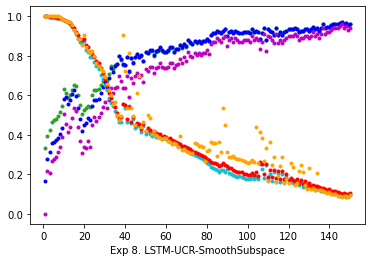

In [6]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 8'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [7]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()

